In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import numpy as np

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

plots = {}

In [16]:
!uv add scikit-learn

Resolved 83 packages in 631ms                                        
Prepared 4 packages in 3.86s                                             
Installed 4 packages in 27ms                                
 + joblib==1.5.3
 + scikit-learn==1.8.0
 + scipy==1.17.0
 + threadpoolctl==3.6.0


In [9]:
folder_path = './Aruco_dataset'
files = os.listdir(folder_path)
print(files)

['dataset3.csv', 'dataset4.csv', 'dataset1.csv', 'dataset2.csv']


In [10]:
df = pd.read_csv(folder_path+'/dataset1.csv')
df.shape

(27577, 40)

# Time series

In [11]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0]]
        y.append(label)
    return np.array(X), np.array(y)

window_size = 5
X, y = df_to_X_y(df, window_size)
X.shape, y.shape

((27572, 5, 40), (27572, 1))

In [12]:
total = len(X)
split1 = int(total * 0.70)
split2 = split1 + int(total * 0.15)
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((19300, 5, 40),
 (19300, 1),
 (4135, 5, 40),
 (4135, 1),
 (4137, 5, 40),
 (4137, 1))

In [18]:
nsamples, ntimesteps, nfeatures = X_train.shape
X_train_2d = X_train.reshape(-1, nfeatures)
X_val_2d   = X_val.reshape(-1, nfeatures)
X_test_2d  = X_test.reshape(-1, nfeatures)

scaler = StandardScaler()
scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(nsamples, ntimesteps, nfeatures)
X_val_scaled   = scaler.transform(X_val_2d).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

### CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten

input_layer = Input(shape=(window_size, 40))

x = Conv1D(64, kernel_size=2)(input_layer)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1441 - root_mean_squared_error: 1.0407 - val_loss: 0.1545 - val_root_mean_squared_error: 0.3931
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0899 - root_mean_squared_error: 0.2997 - val_loss: 0.0793 - val_root_mean_squared_error: 0.2816
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2325
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0365 - root_mean_squared_error: 0.1909 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1930
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1651
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1457
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3m

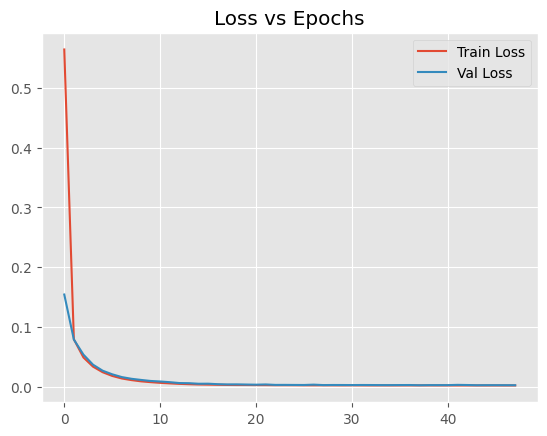

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
model.save(folder_path + "/models/cnn_40f_rand.keras")

In [ ]:
from tensorflow import keras
model = keras.models.load_model(folder_path + "/models/cnn_40f_rand.keras")

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


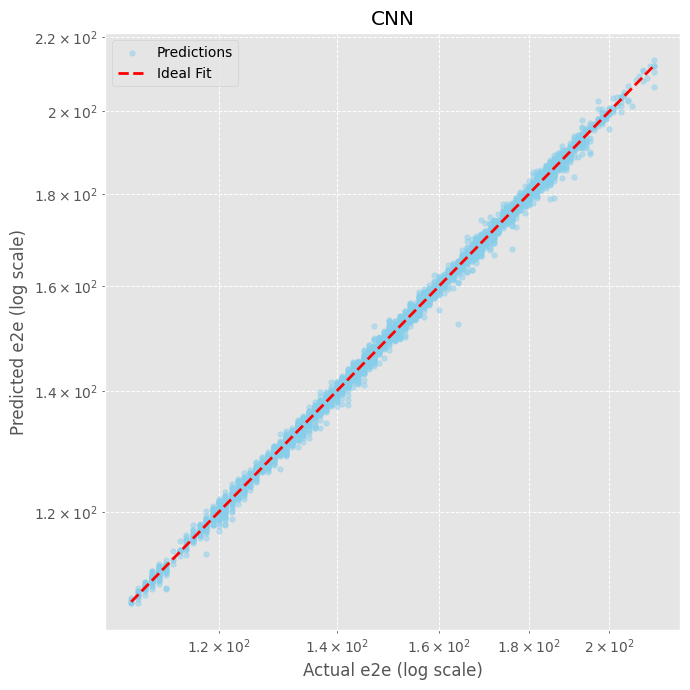

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("CNN")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["CNN"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.7866
MSE:  1.1692
RMSE: 1.0813
R²:   0.9978


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step


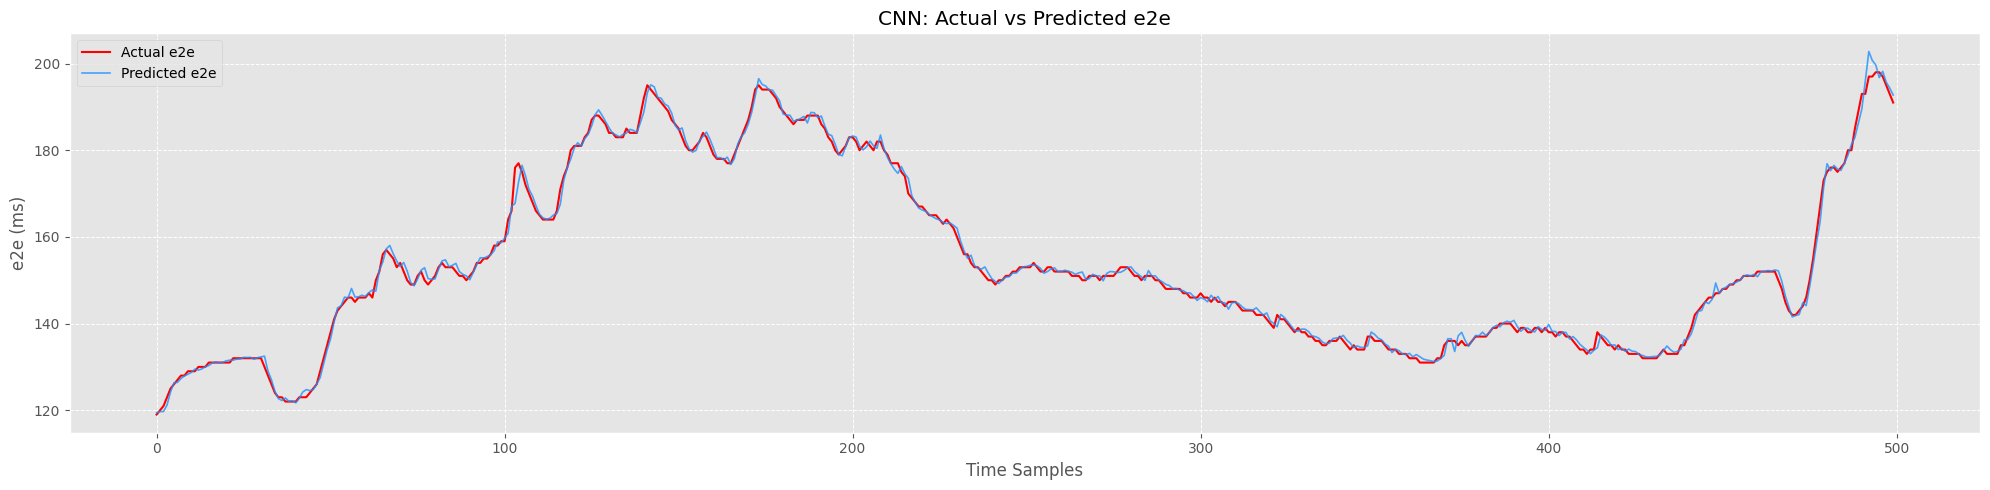

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### GRU

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D,  GRU
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = GRU(64)(input_layer)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        20,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,881 (81.57 KB)

 Trainable params: 20,881 (81.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.3417 - root_mean_squared_error: 0.5701 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2623
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0406 - root_mean_squared_error: 0.2011 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0181 - root_mean_squared_error: 0.1347 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1384
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 7m

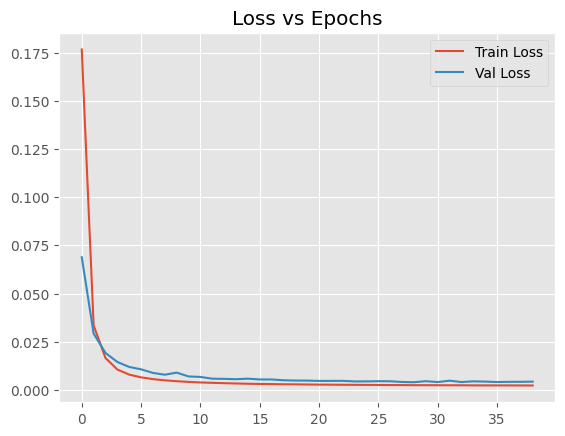

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
model.save(folder_path + "/models/gru_40f_rand.keras")

In [ ]:
from tensorflow import keras
model = keras.models.load_model(folder_path + "/models/gru_40f_rand.keras")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


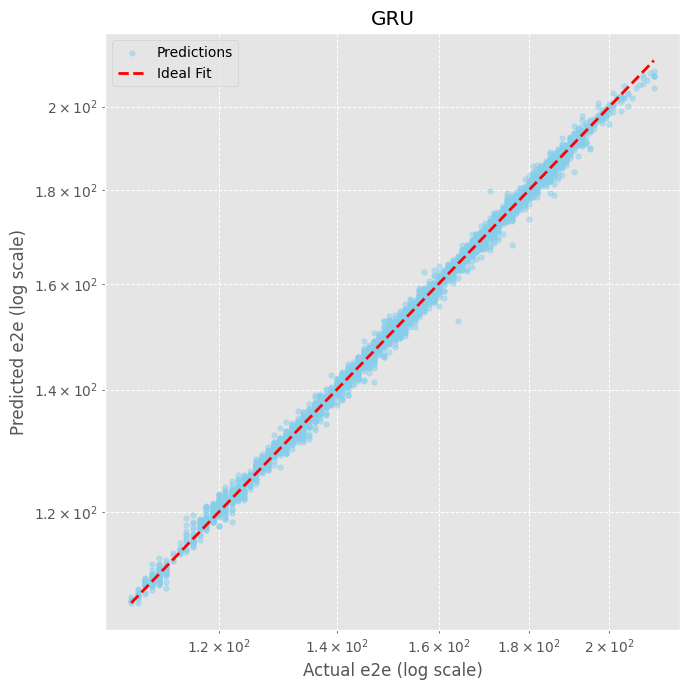

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("GRU")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["GRU"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.9317
MSE:  1.5670
RMSE: 1.2518
R²:   0.9971


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


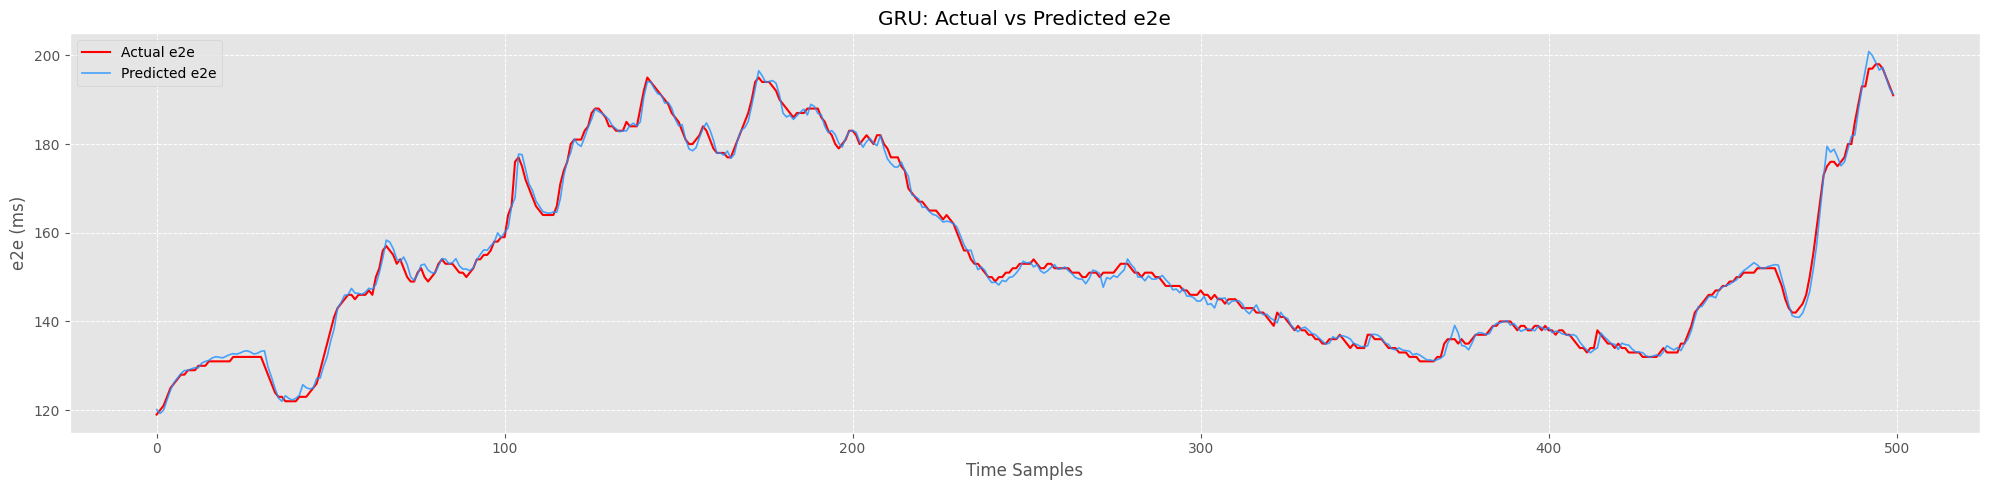

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("GRU: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = LSTM(64)(input_layer)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,409 (107.07 KB)

 Trainable params: 27,409 (107.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3293 - root_mean_squared_error: 0.5550 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2585
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0384 - root_mean_squared_error: 0.1956 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1933
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1623
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1302
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6m

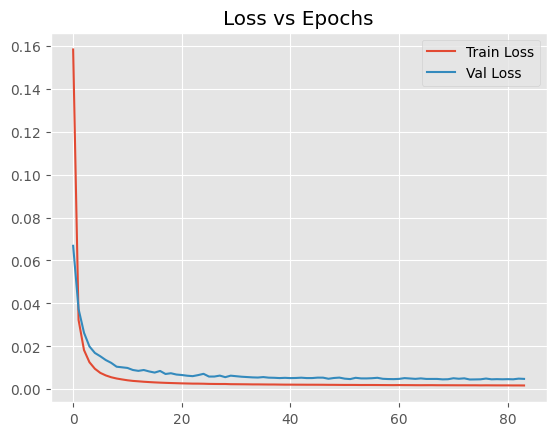

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
model.save(folder_path + "/models/lstm_40f_rand.keras")

In [19]:
from tensorflow import keras

model = keras.models.load_model(folder_path + "/models/lstm_40f_rand.keras")

E0000 00:00:1770633021.004448    7269 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770633021.011109    7269 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


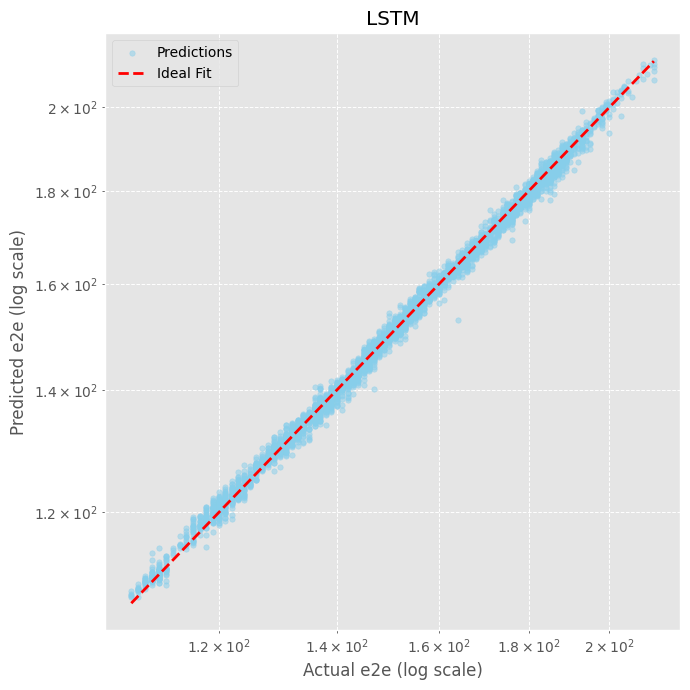

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("LSTM")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["LSTM"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  1.0176
MSE:  1.8030
RMSE: 1.3427
R²:   0.9967


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


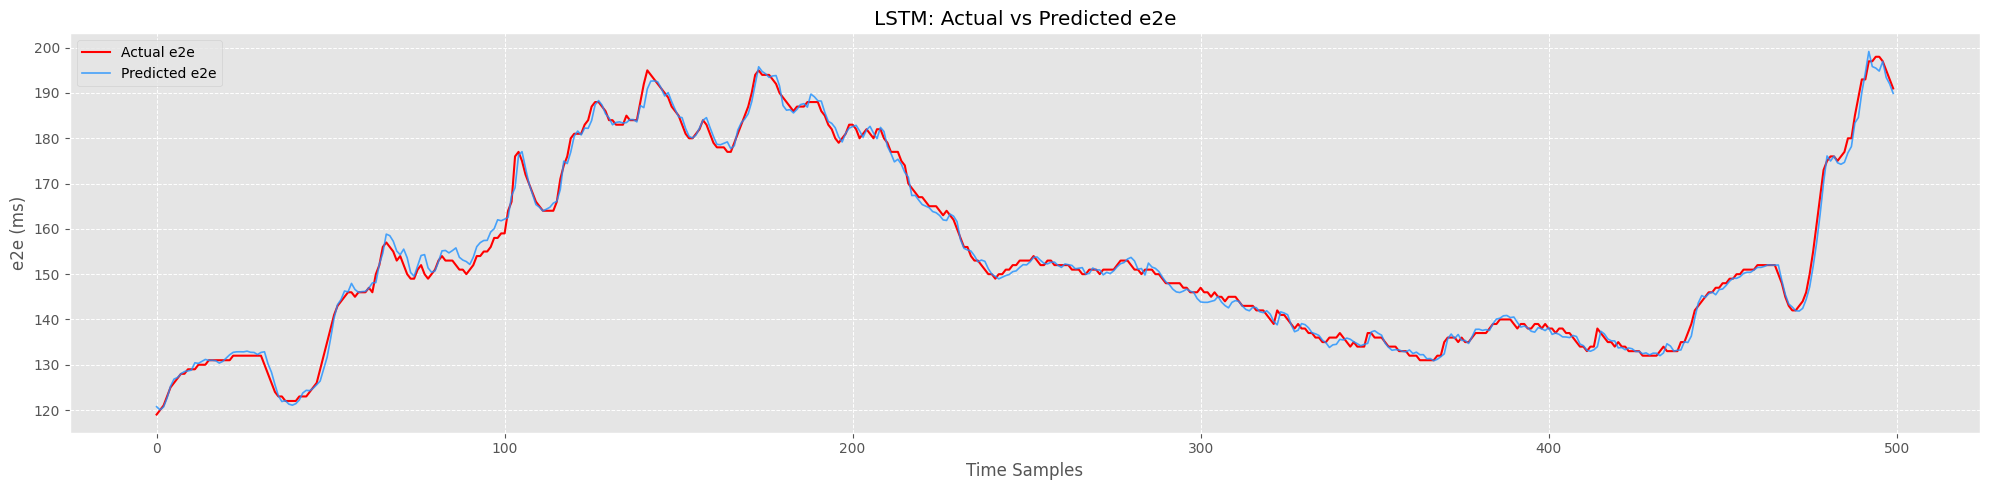

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### CNN + LSTM

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = Conv1D(64, kernel_size=2, padding='same', activation='relu')(input_layer)
#x = MaxPooling1D(pool_size=2)(x)
#x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737 (151.32 KB)

 Trainable params: 38,737 (151.32 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [23]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2027 - root_mean_squared_error: 0.4502 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2223
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1617
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3m

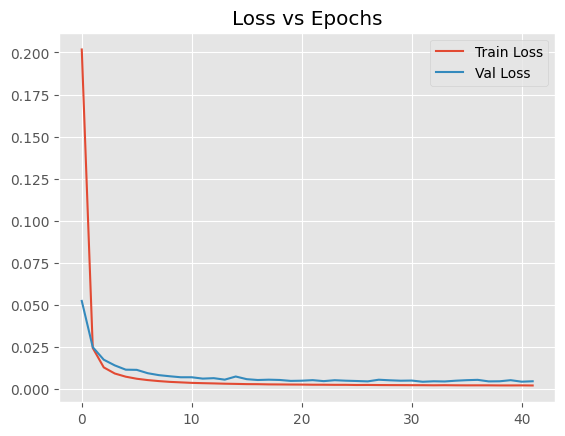

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
model.save(folder_path + "/models/cnn_lstm_40f_rand.keras")

In [ ]:
from tensorflow import keras

model = keras.models.load_model(folder_path + "/models/cnn_lstm_40f_rand.keras")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


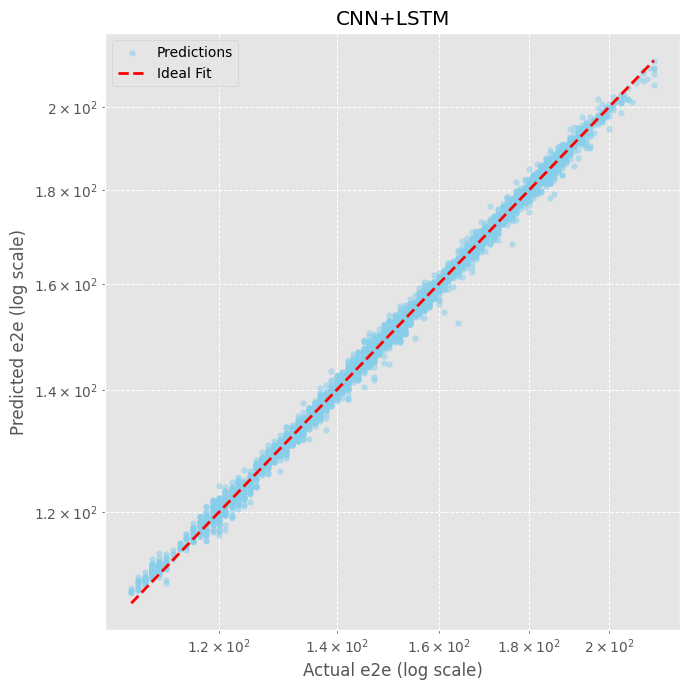

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("CNN+LSTM")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["CNN+LSTM"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.9990
MSE:  1.7343
RMSE: 1.3169
R²:   0.9968


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


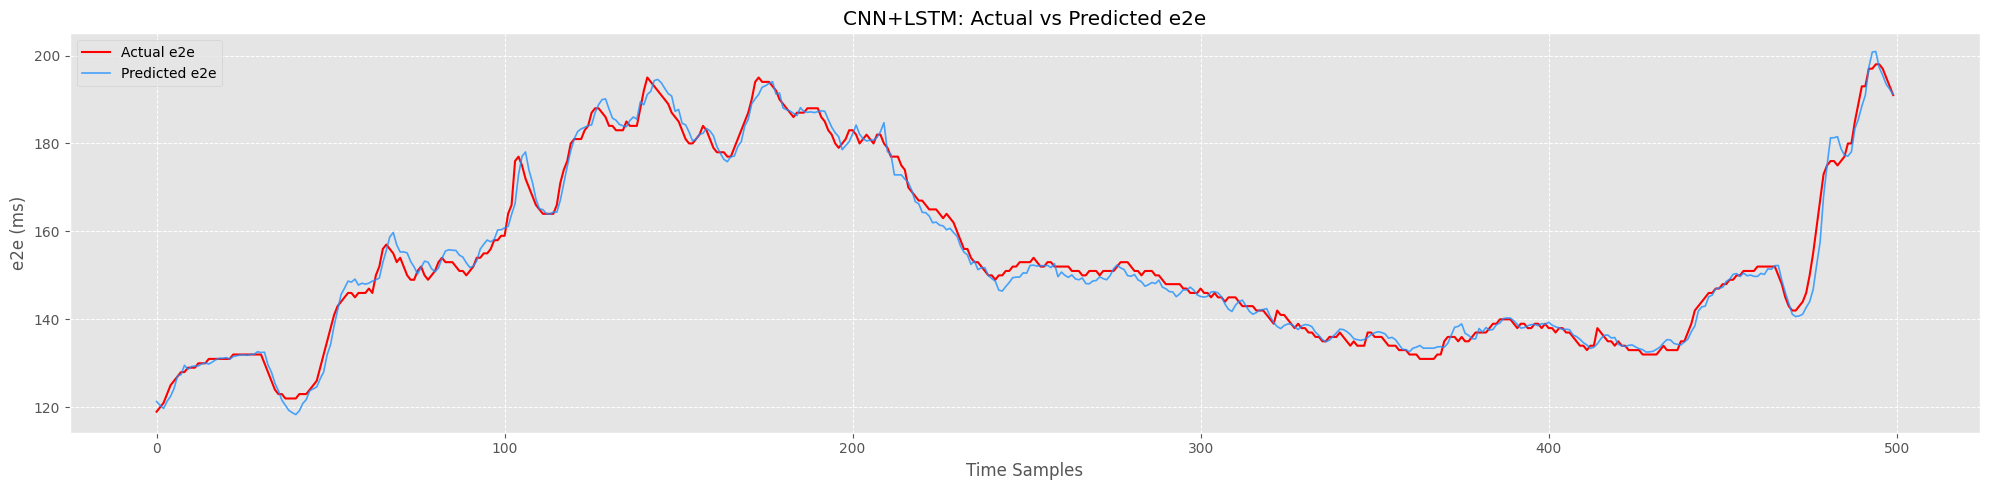

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN+LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


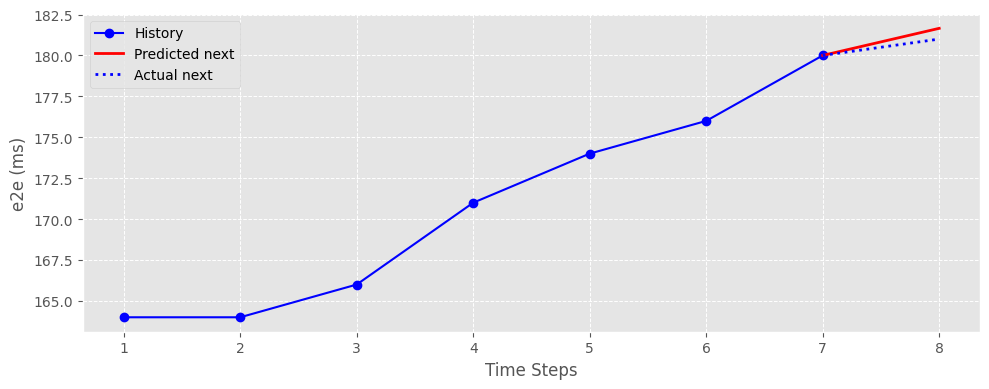

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

start_idx = 1120

X_window = X_val_scaled[start_idx].reshape(1, 5, 40)

y_pred_scaled = model.predict(X_window)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))[0, 0]

y_true = y_scaler.inverse_transform(y_val_scaled[start_idx].reshape(-1, 1))[0, 0]

y_history = y_scaler.inverse_transform(
    y_val_scaled[start_idx-7:start_idx].reshape(-1, 1)
).flatten()

plt.figure(figsize=(10, 4))

plt.plot(range(1, 8), y_history, marker="o", color="blue", label="History")

plt.plot([7, 8], [y_history[-1], y_pred], "-", color="red", linewidth=2, label="Predicted next")

plt.plot([7, 8], [y_history[-1], y_true], ":", color="blue", linewidth=2, label="Actual next")

plt.xlabel("Time Steps")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


# Regression

In [ ]:
def df_to_X_y(df, target_col="e2e"):
    X = df.drop(columns=[target_col]).to_numpy()
    y = df[target_col].to_numpy()
    return X, y

X, y = df_to_X_y(df)
print(X.shape, y.shape)

(27577, 39) (27577,)


In [ ]:
total = len(X)  
split1 = int(total * 0.70)
split2 = split1 + int(total * 0.15)
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((19303, 39), (19303,), (4136, 39), (4136,), (4138, 39), (4138,))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled   = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_scaled, y_train_scaled)
y_pred = reg.predict(X_test_scaled)

print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)


Coefficients: [ 1.87368536e-01  4.38985573e-01  6.66306376e-02  6.54142221e-02
  1.10198498e-01 -7.79968341e-03  5.81785185e-02 -3.41545227e-02
 -8.20652643e-02  4.10798092e-02 -6.26633017e-03 -1.30821587e-02
 -3.54027708e-02 -5.15338222e-02 -6.17469231e-02 -2.92005713e-02
 -5.52948902e-02 -6.25992802e-02 -1.29155906e-01  1.08391028e-02
 -4.88230072e-02 -4.93599885e-02  6.67699223e-03  2.76326986e-03
 -6.39197436e-02 -6.50636088e-02 -1.49933286e-02  9.93747563e+01
  1.11829616e+02 -1.03777623e+02  3.26710618e+05 -3.26817784e+05
 -2.95732576e-02  2.24885143e+02  2.24570445e+02 -2.25849209e+02
  8.25392362e+04 -8.27629242e+04 -1.55180863e-03]
Intercept: -9.9271861821995e-11


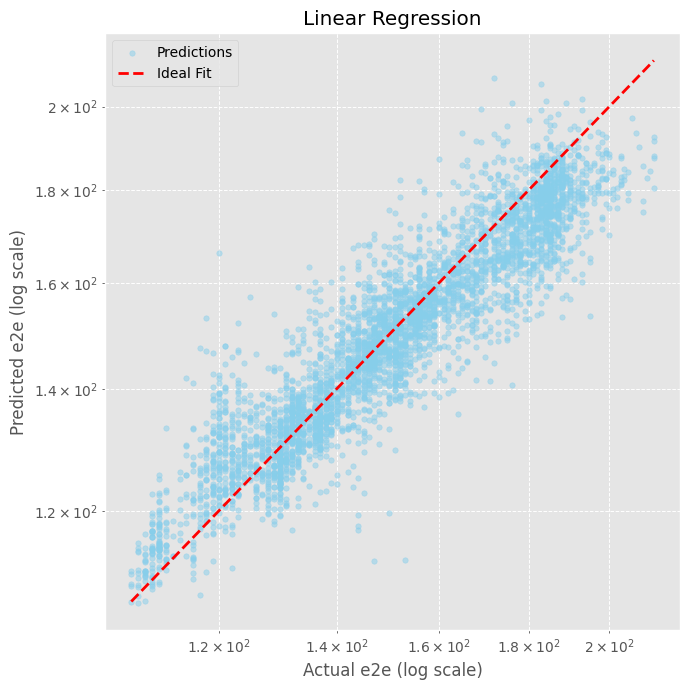

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = reg.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("Linear Regression")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()

fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["LinearReg"] = (fig, ax)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  7.0292
MSE:  87.7936
RMSE: 9.3698
R²:   0.8371


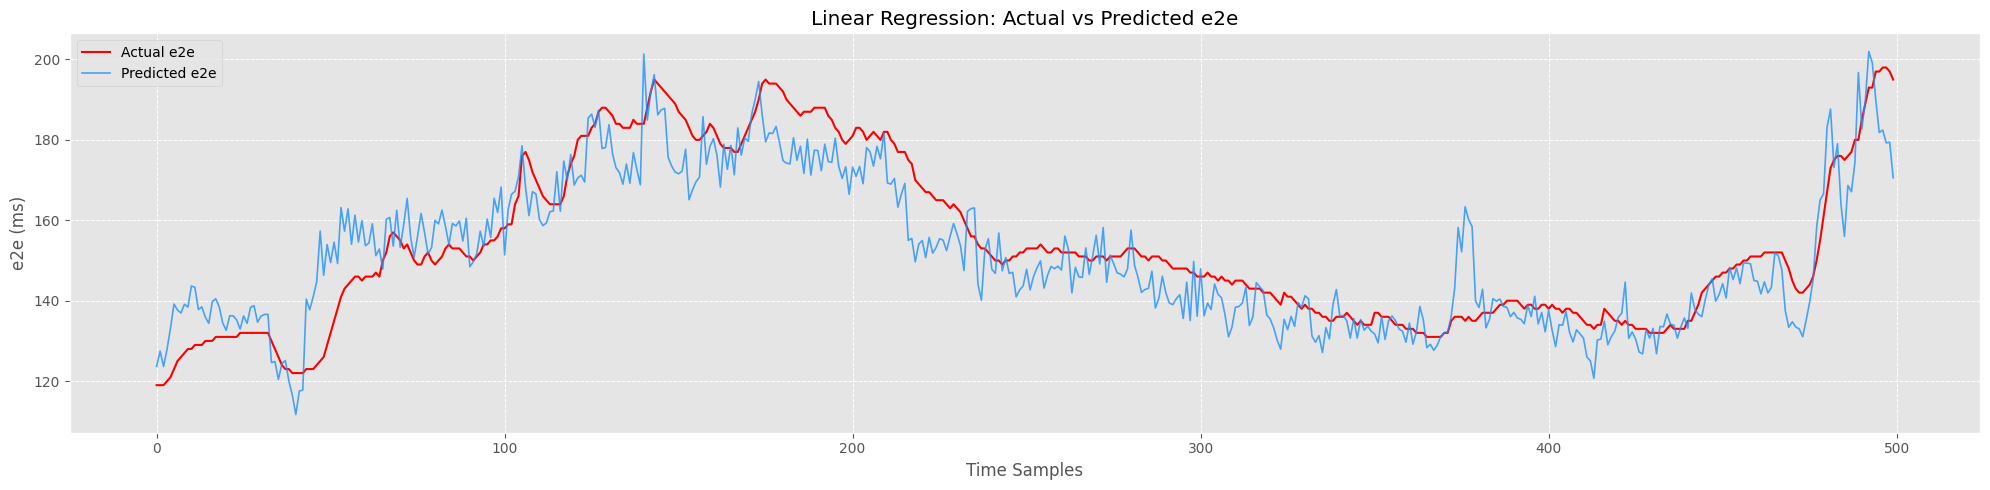

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = reg.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Linear Regression: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Tree Based Models

### Random forrest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_scaled)
y_pred = rf.predict(X_val_scaled)

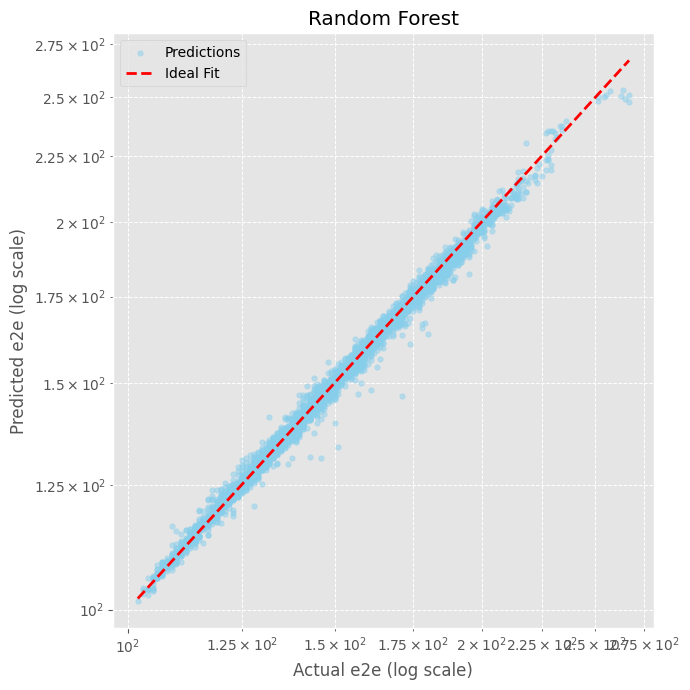

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = rf.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("Random Forest")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["RandForest"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  1.5053
MSE:  4.8274
RMSE: 2.1971
R²:   0.9930


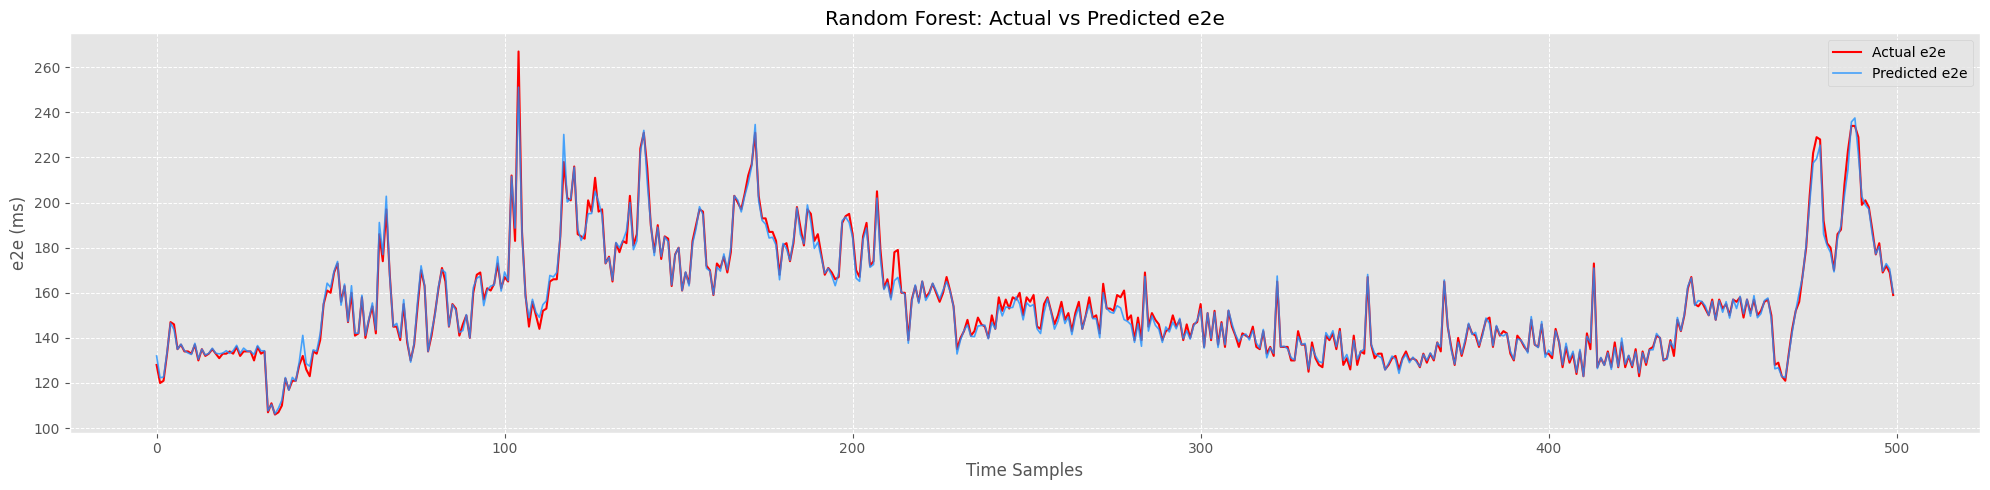

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = rf.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Random Forest: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### Gradient Boosting

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train_scaled)
y_pred = xgb.predict(X_val_scaled)


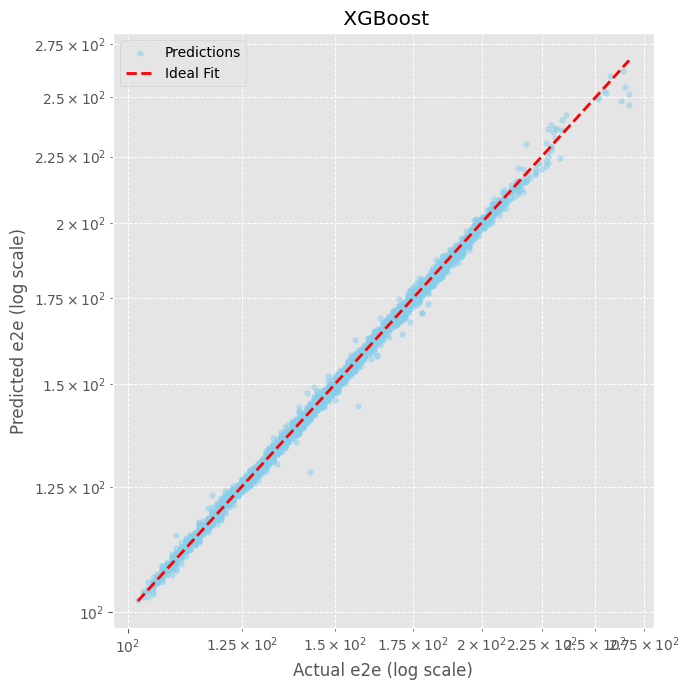

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = xgb.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title(" XGBoost")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["XGBoost"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.9257
MSE:  1.8927
RMSE: 1.3757
R²:   0.9973


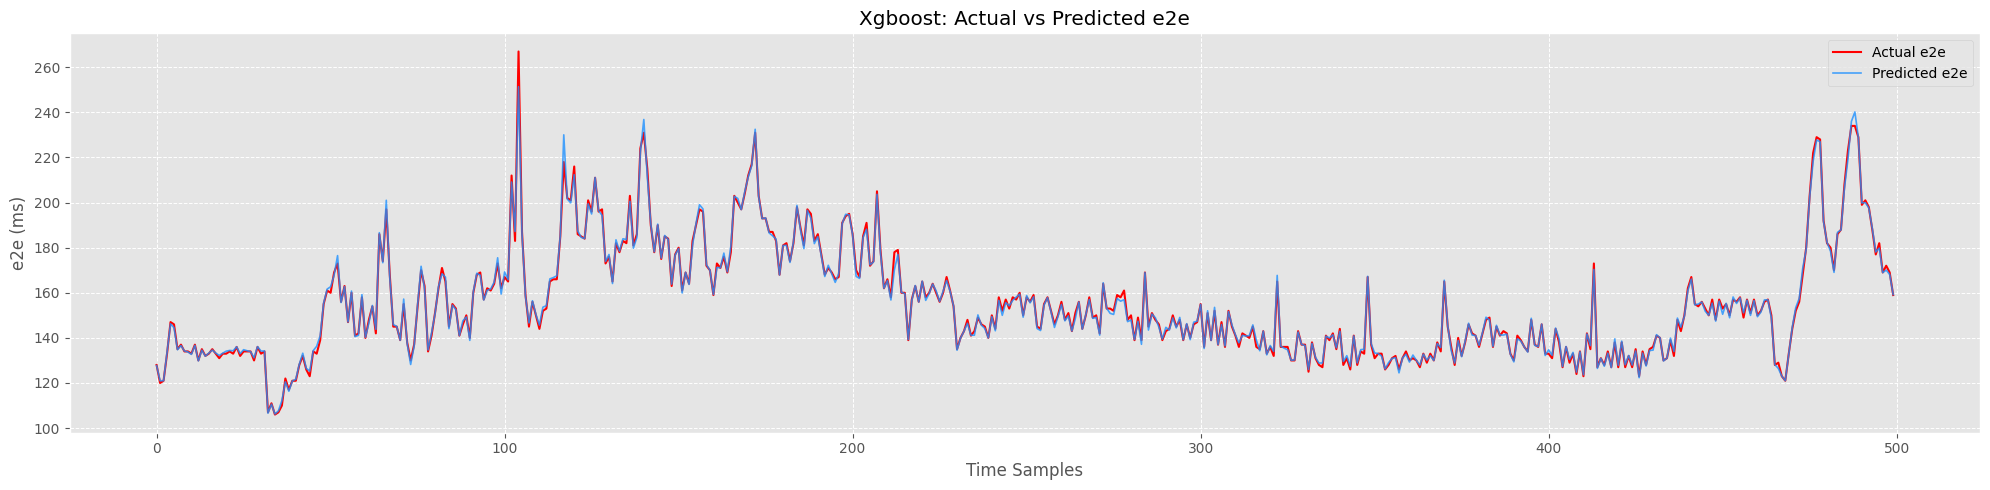

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = xgb.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Xgboost: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Neural Networks (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train_scaled)
y_pred = mlp.predict(X_val_scaled)

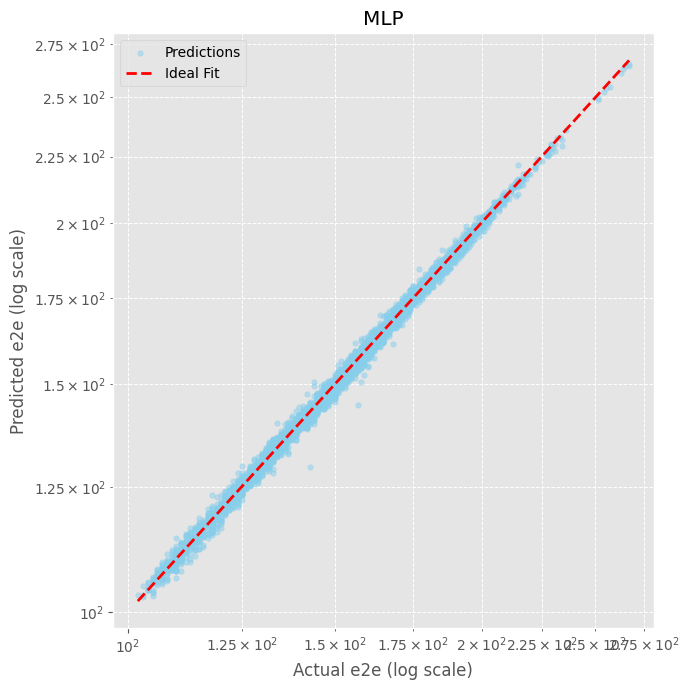

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = mlp.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("MLP")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["MLP"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  1.1902
MSE:  2.3517
RMSE: 1.5335
R²:   0.9966


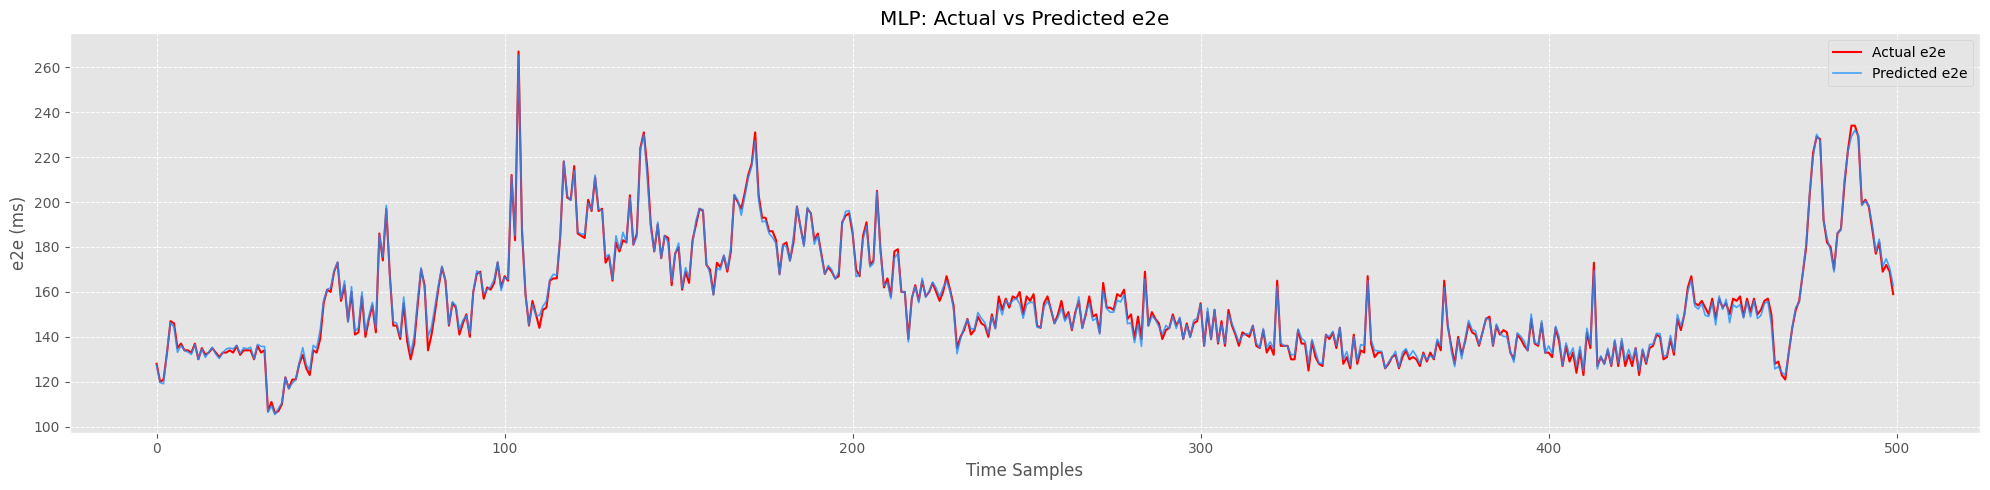

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = mlp.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("MLP: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Arima

Bad for latency prediction. Takes too much time for computation

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import itertools

In [ ]:
ts = df['e2e']
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is non stationary; differencing is needed.")
else:
    print("Series is stationary; no differencing needed.")

ADF Statistic: -9.669885
p-value: 0.000000
Series is stationary; no differencing needed.


In [ ]:
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(y_train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA order: (2, 1, 3) with AIC: 56961.193307262045


In [ ]:
final_model = ARIMA(ts, order=(3, 0, 3))
results = final_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_values = results.forecast(steps=10)

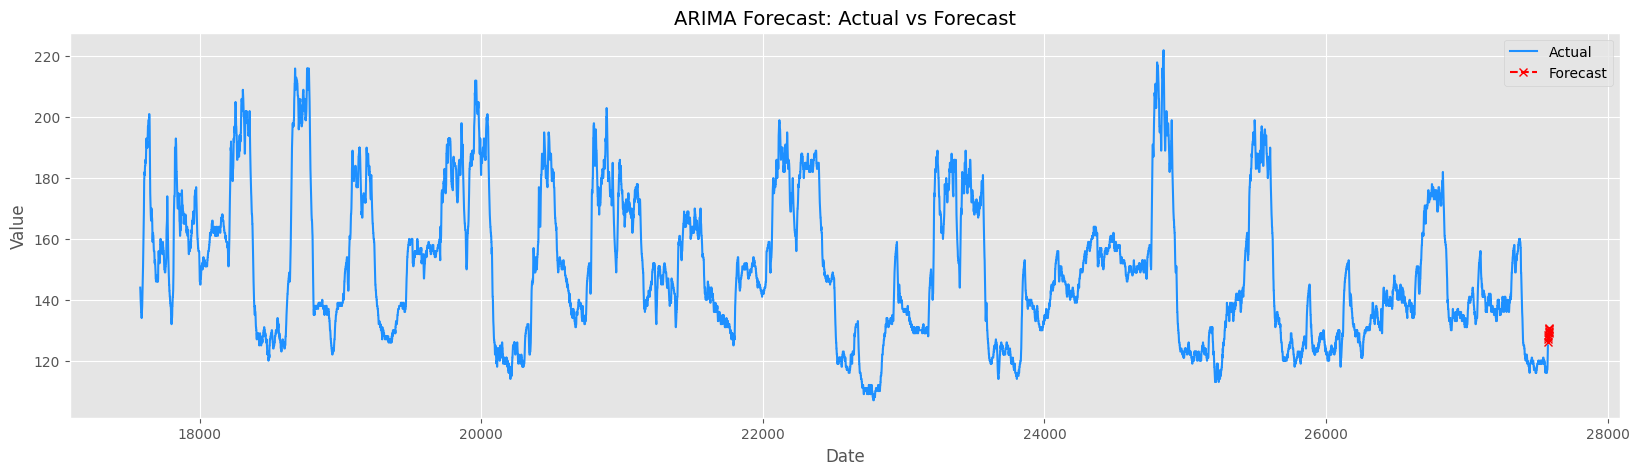

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(ts[-10000:].index, ts[-10000:], label='Actual', color='dodgerblue', linestyle='-')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red', linestyle='--', marker='x')

plt.title('ARIMA Forecast: Actual vs Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
final_model = ARIMA(y_train, order=(2, 1, 3))
results = final_model.fit()

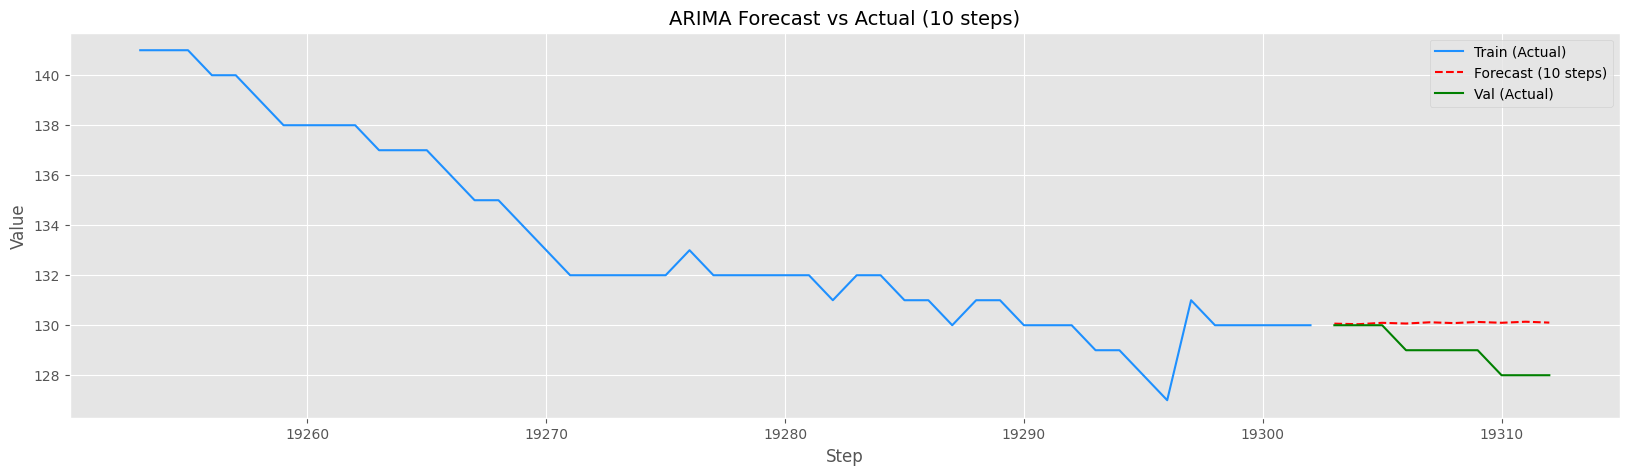

In [ ]:
plt.figure(figsize=(20, 5))

to_forecast = 10
forecast_values = results.forecast(steps=to_forecast)

tail = 50
n_train = len(y_train)
start = max(0, n_train - tail)

x_train = range(start, n_train)
y_train_tail = y_train[start:]

y_val_crop = y_val[:to_forecast]
x_forecast = range(n_train, n_train + len(forecast_values))
x_val      = range(n_train, n_train + len(y_val_crop))

plt.plot(x_train, y_train_tail,
         label='Train (Actual)', color='dodgerblue', linestyle='-')

plt.plot(x_forecast, getattr(forecast_values, "values", forecast_values),
         label=f'Forecast ({to_forecast} steps)', color='red', linestyle='--')

plt.plot(x_val, y_val_crop,
         label='Val (Actual)', color='green', linestyle='-')

plt.title(f'ARIMA Forecast vs Actual ({to_forecast} steps)', fontsize=14)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
y_train.shape, y_test.shape, y_val.shape

((19303,), (4138,), (4136,))

# Comparision

In [ ]:
from tabulate import tabulate

def add_metrics(label: str, metrics_str: str):
    metrics = {}
    for line in metrics_str.strip().splitlines():
        if ":" in line:
            key, val = line.split(":")
            metrics[key.strip()] = float(val.strip())
    results[label] = metrics

results = {}

In [ ]:
headers = ["Model"] + list(next(iter(results.values())).keys())
table = [[label] + [metrics[k] for k in headers[1:]] for label, metrics in results.items()]

print(tabulate(table, headers=headers, floatfmt=".4f"))

Model            MAE      MSE    RMSE      R²
------------  ------  -------  ------  ------
Linear Reg    7.0292  87.7936  9.3698  0.8371
Rand Forrest  6.5824  74.1065  8.6085  0.8625
XGboost       5.9926  62.2512  7.8899  0.8845
MLP           7.4515  96.0256  9.7993  0.8218
CNN           0.7970   1.2314  1.1097  0.9977
GRU           0.9606   1.6668  1.2910  0.9969
LSTM          1.0229   1.8304  1.3529  0.9966
CNN+LSTM      0.9774   1.6663  1.2909  0.9969


In [ ]:
print(plots.keys())

dict_keys(['LinearReg', 'RandForest', 'XGBoost', 'MLP', 'CNN', 'GRU', 'LSTM', 'CNN+LSTM'])


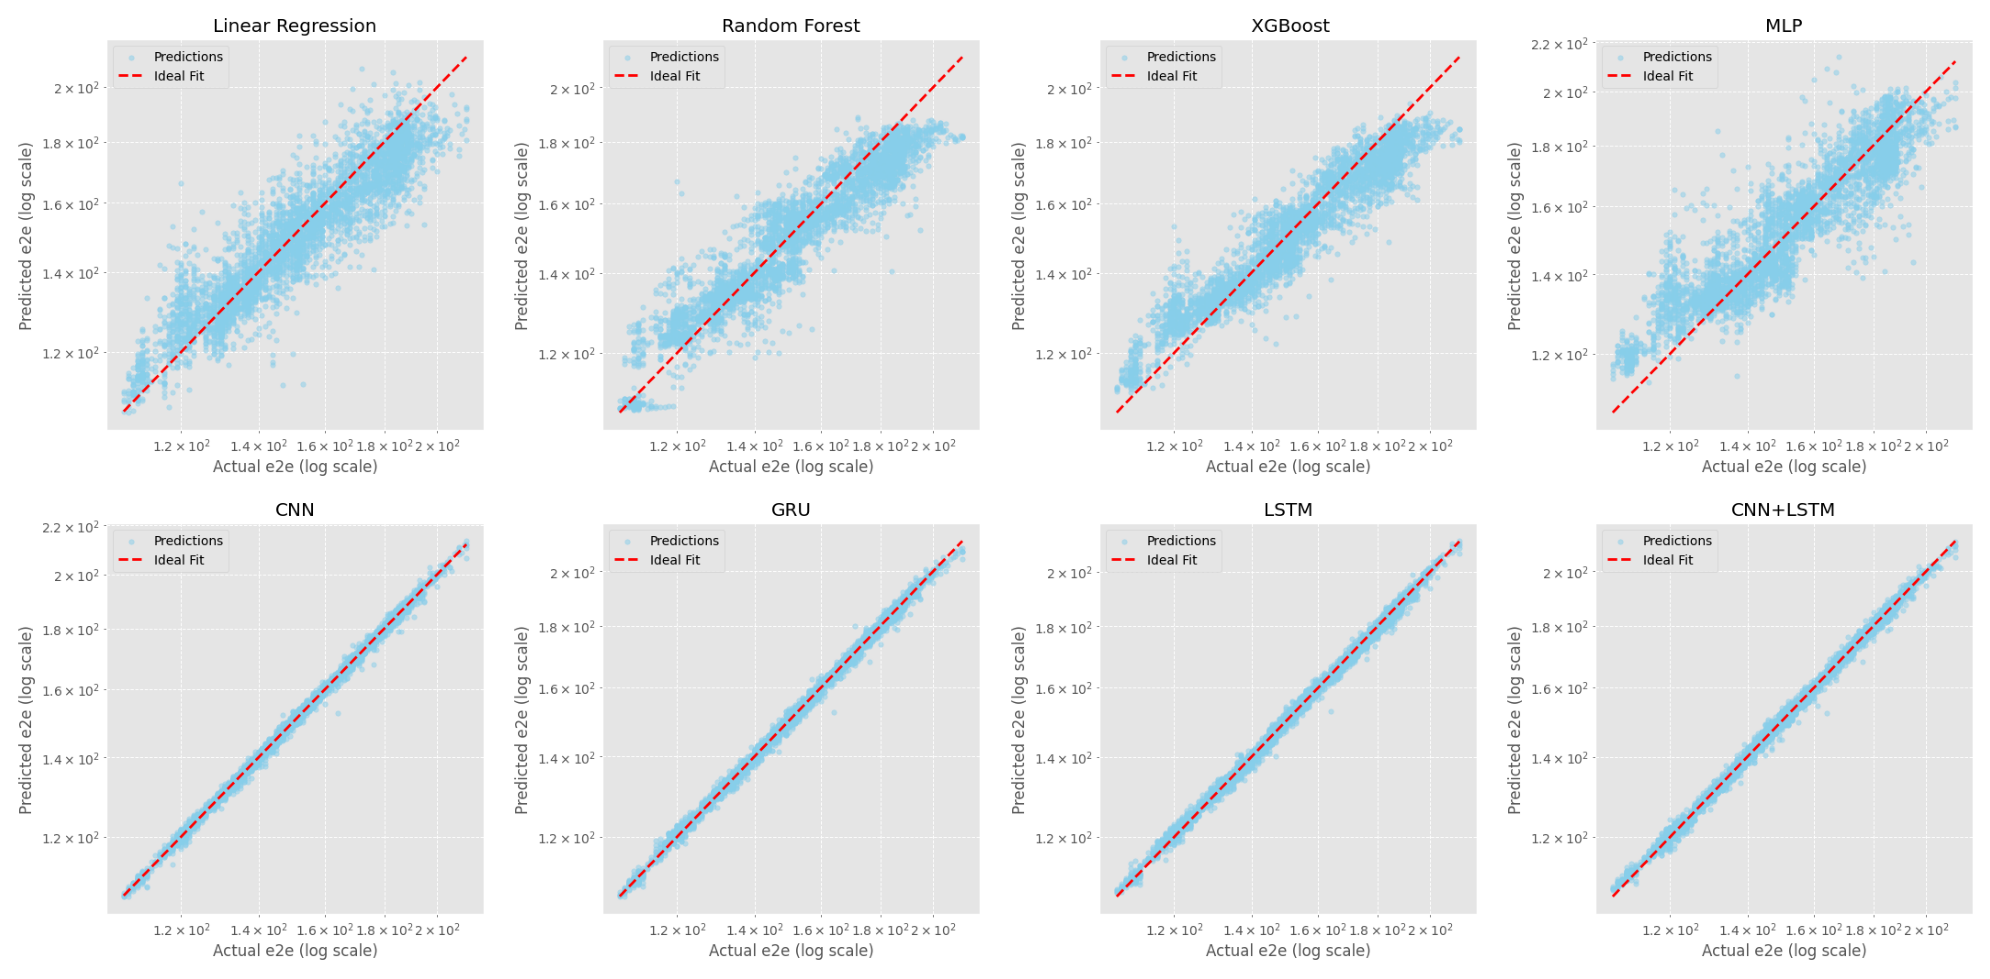

In [ ]:
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


labels = ['LinearReg', 'RandForest', 'XGBoost', 'MLP',
          'CNN', 'GRU', 'LSTM', 'CNN+LSTM']

grid_fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, label in enumerate(labels):
    fig, ax = plots[label]

    fig.set_size_inches(5, 5)

    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100, bbox_inches="tight")
    buf.seek(0)

    img = Image.open(buf)
    axes[i].imshow(img)
    axes[i].axis('off')  

plt.tight_layout()
plt.show()


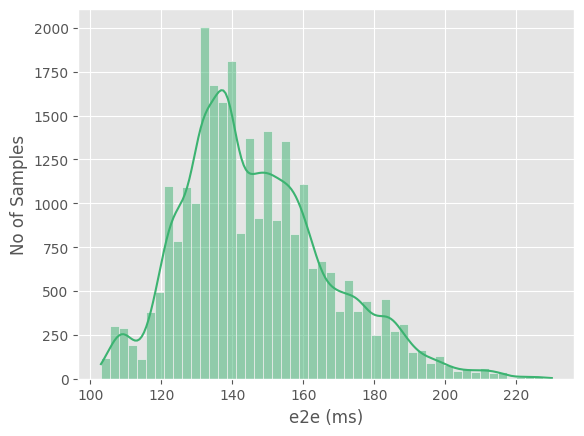

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['e2e'], kde=True, bins=50, color='mediumseagreen')

plt.xlabel('e2e (ms)')
plt.ylabel('No of Samples')
plt.grid(True)
plt.show()

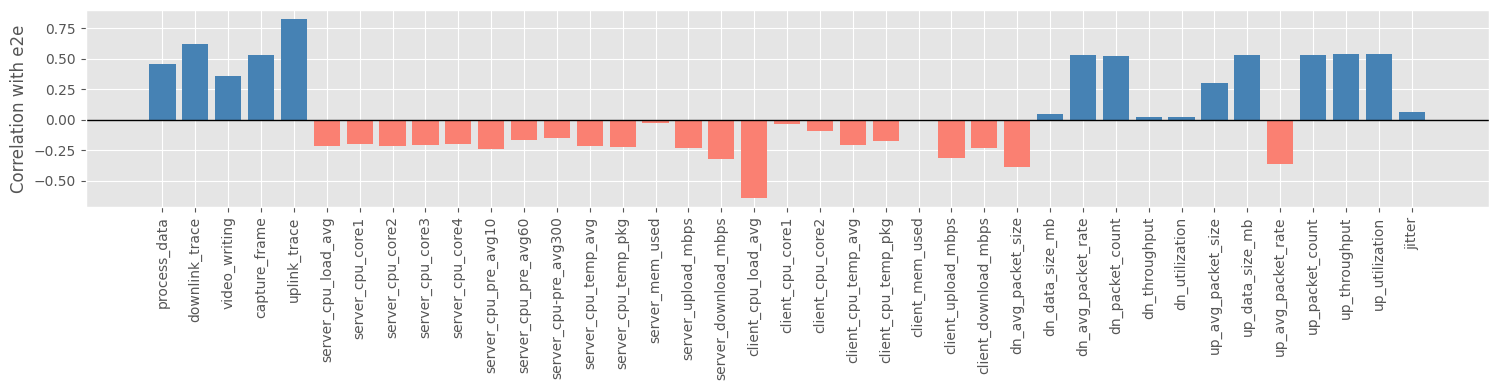

In [ ]:
import matplotlib.pyplot as plt

corr_with_e2e = df.corr()['e2e'].drop('e2e')  

colors = ["steelblue" if v > 0 else "salmon" for v in corr_with_e2e]

plt.figure(figsize=(15, 4))
plt.bar(corr_with_e2e.index, corr_with_e2e.values, color=colors)
plt.axhline(0, color="black", linewidth=1)  

plt.xticks(rotation=90)
plt.ylabel("Correlation with E2E")
plt.tight_layout()
plt.show()



# Plots

In [ ]:
def my_plot(df, to_plot, zoom=slice(None), height=5):
    if isinstance(zoom, tuple):
        zoom = slice(*zoom)

    fig, ax = plt.subplots(figsize=(20, len(to_plot)*height), nrows=len(to_plot))

    if len(to_plot) == 1:
        ax = [ax]

    for i, col in enumerate(to_plot):
        df[col][zoom].plot(ax=ax[i])
        ax[i].set_xlabel(col, fontsize=20)

    plt.tight_layout()
    plt.show()

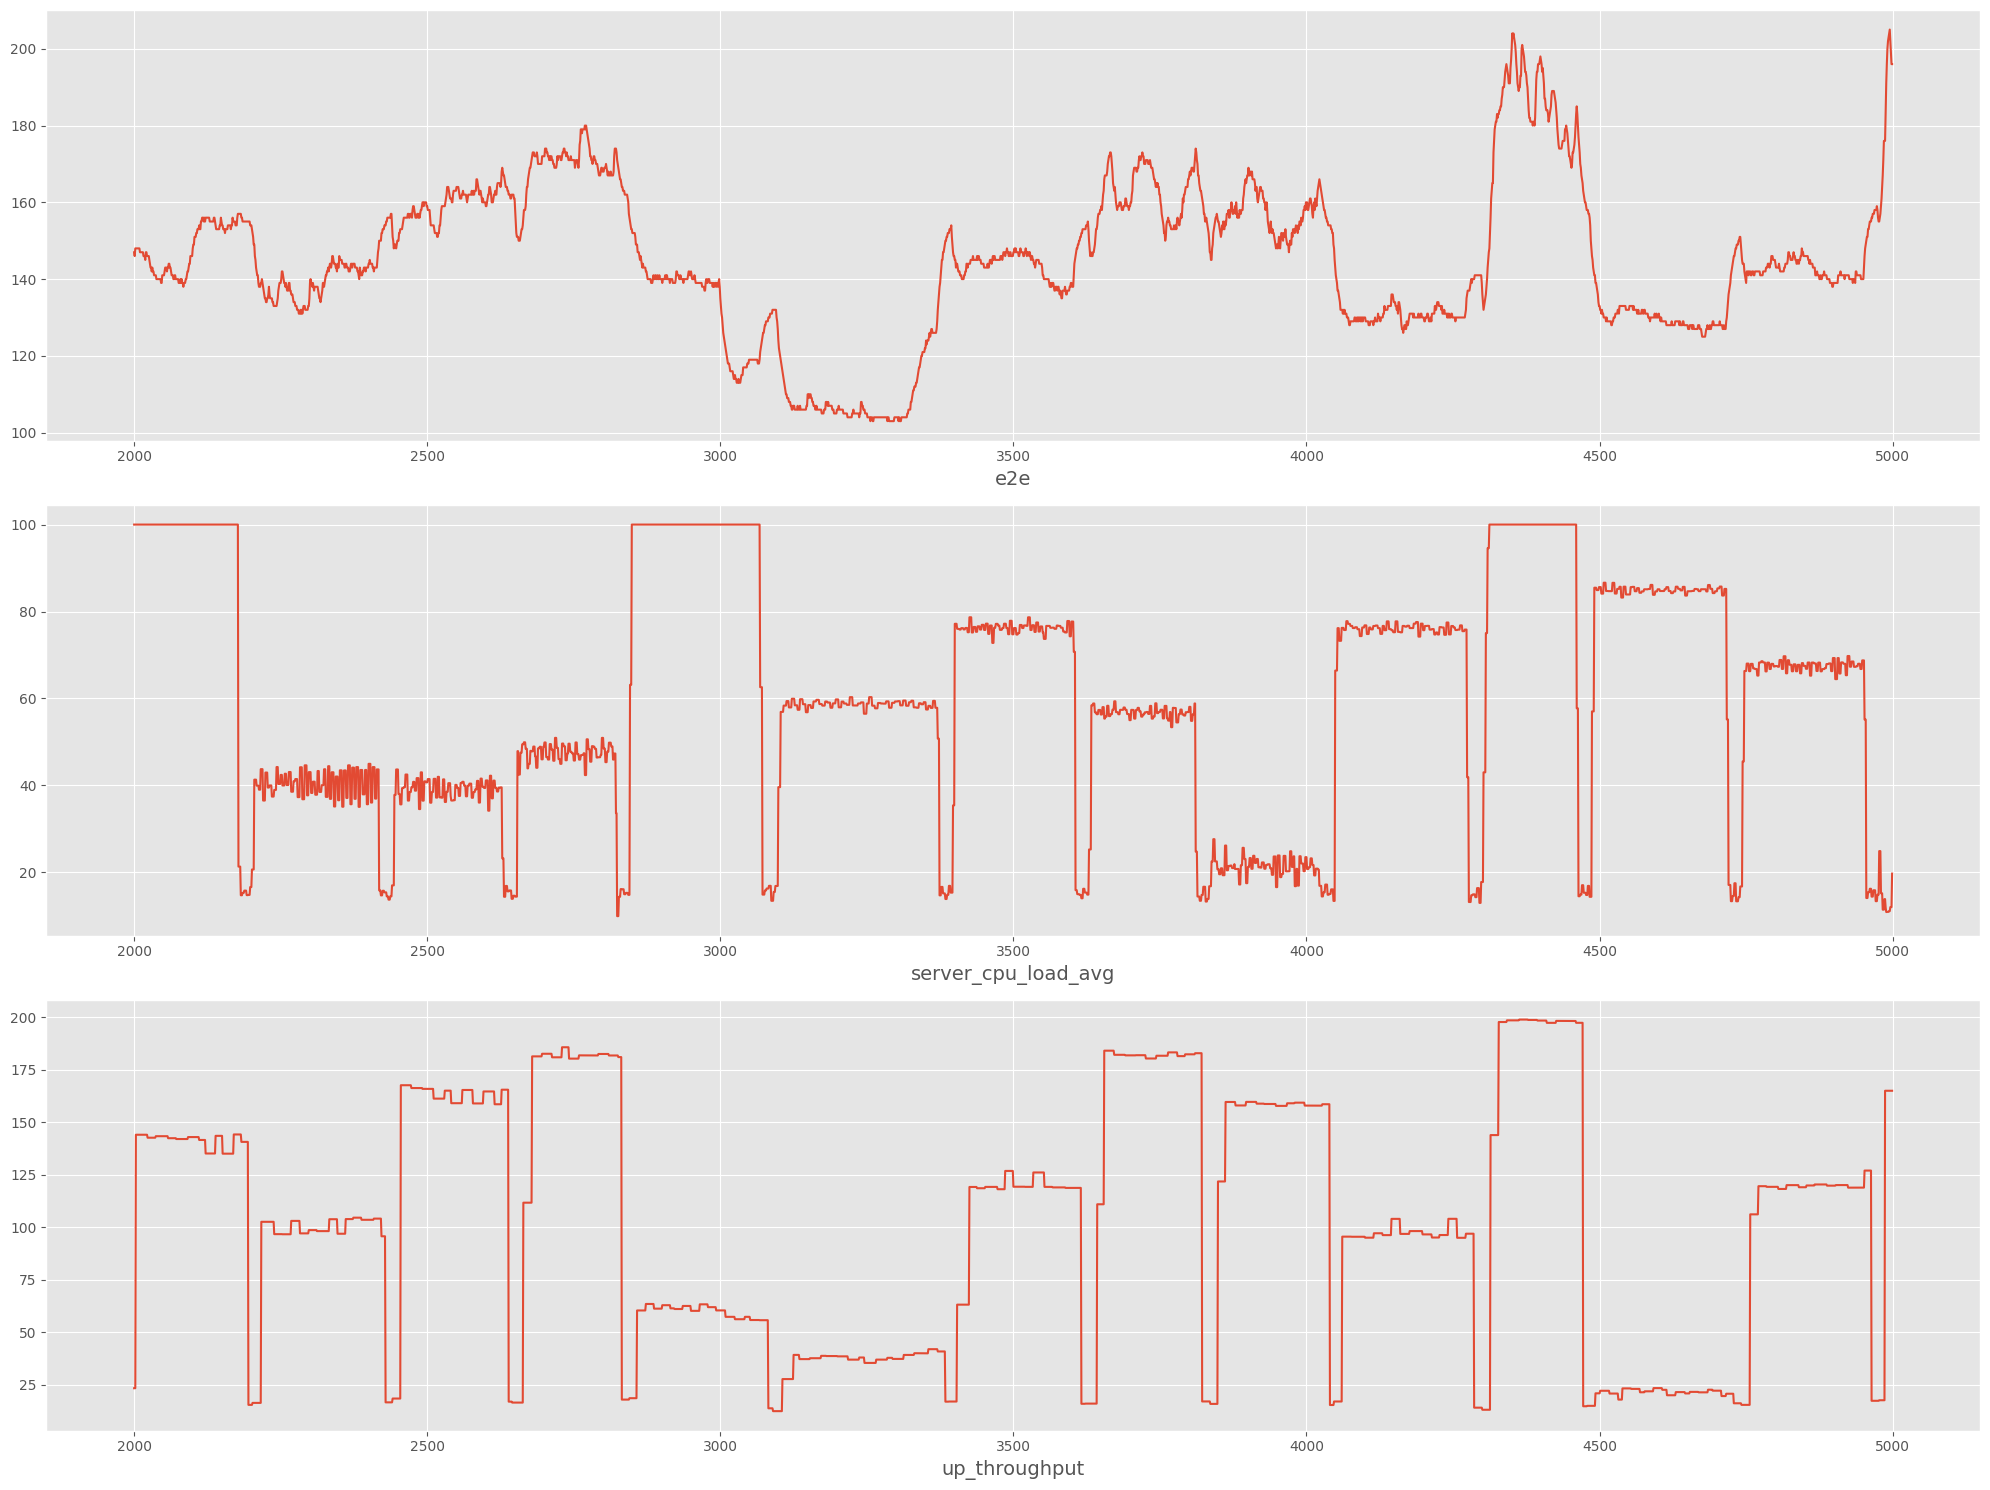

In [ ]:
my_plot(df, ['e2e', 'server_cpu_load_avg', 'up_throughput'], zoom=slice(2000,5000), height=5)

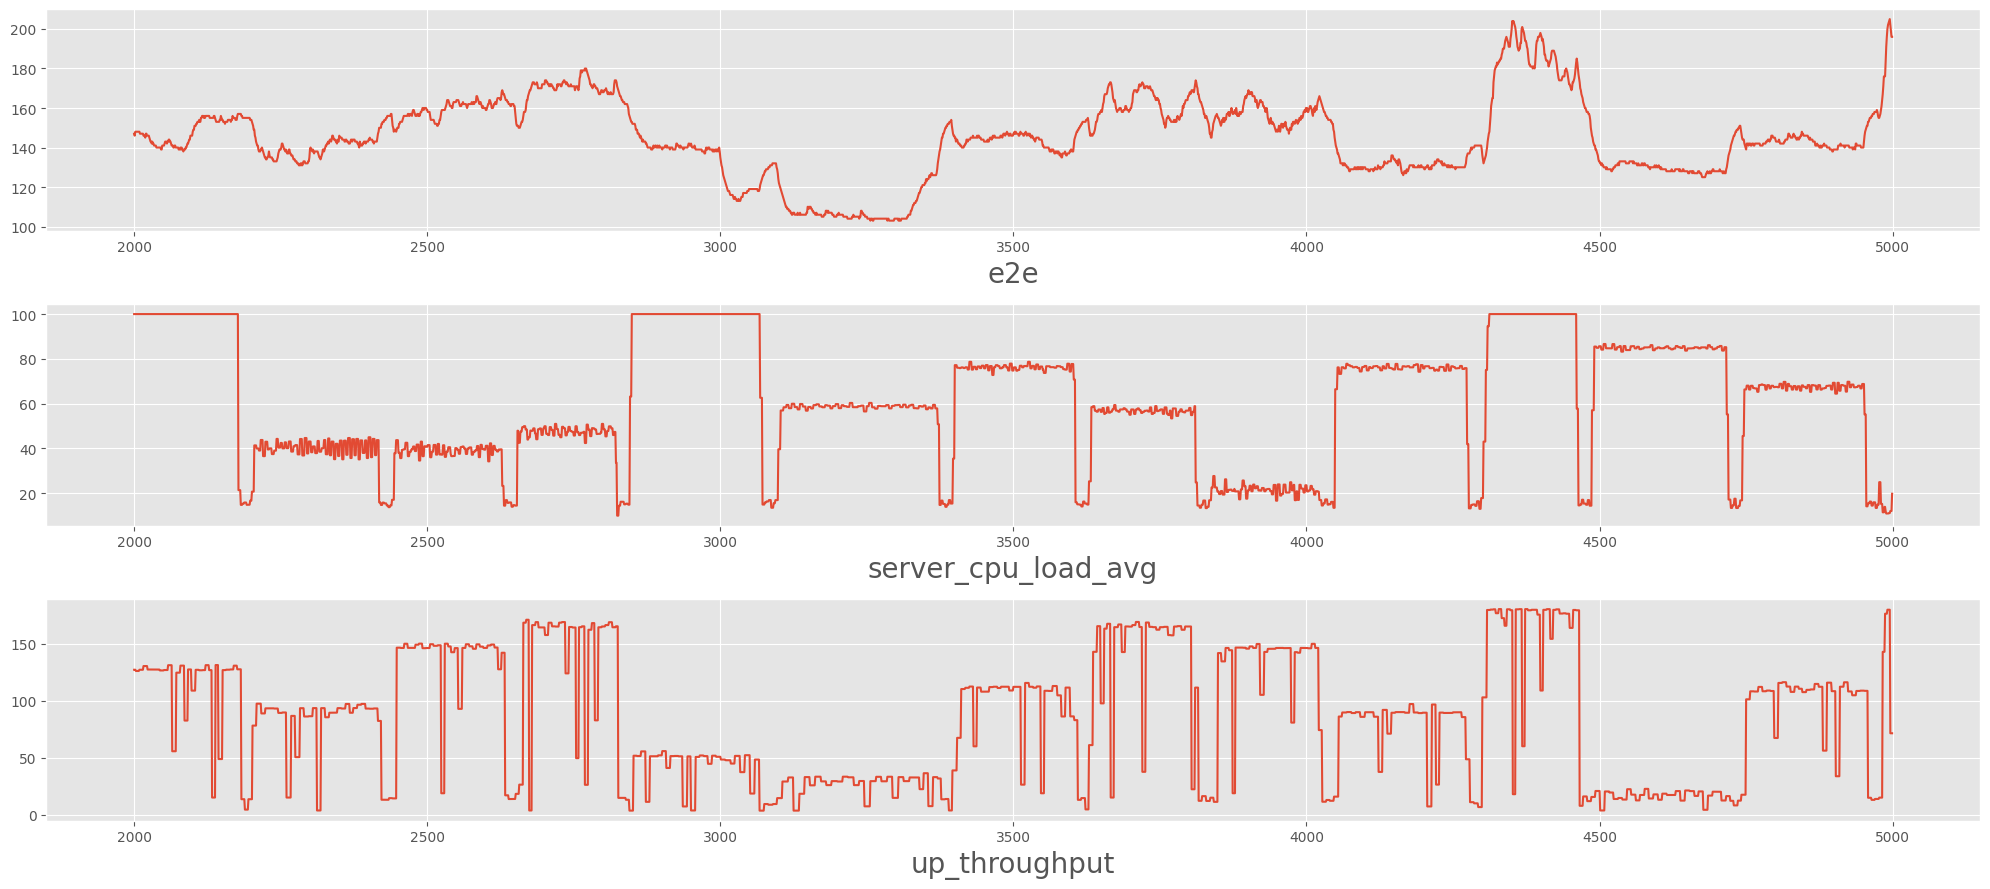

In [ ]:
my_plot(df, ['e2e', 'server_cpu_load_avg', 'up_throughput'], zoom=slice(2000,5000), height=3)

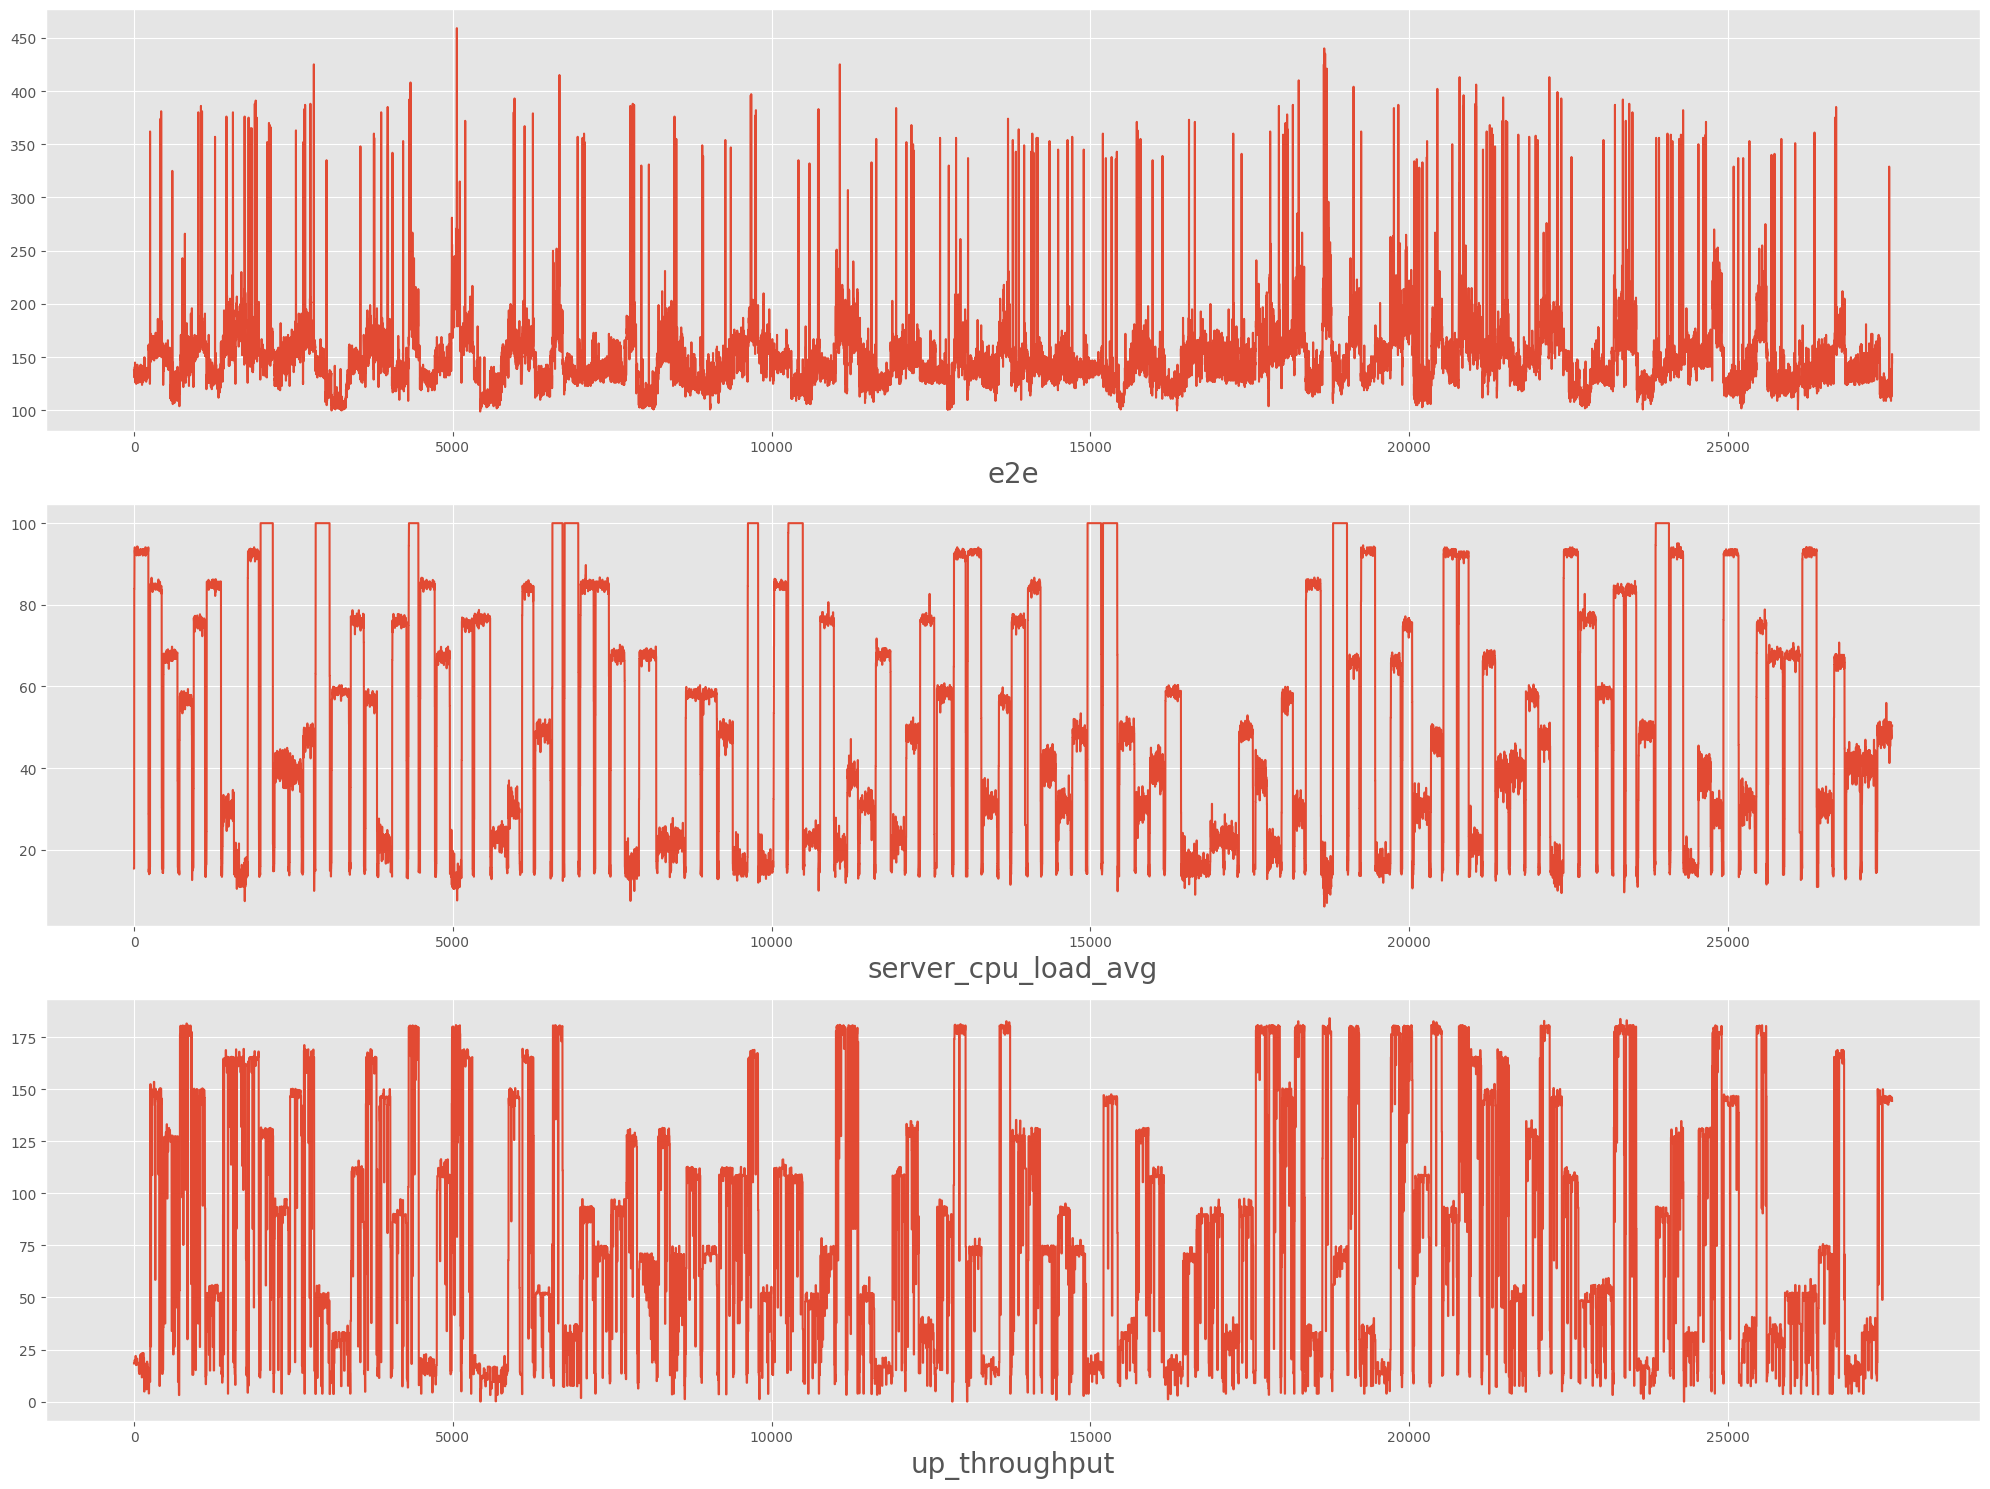

In [ ]:
my_plot(df, ['server_cpu_load_avg', 'up_throughput'], zoom=slice(None), height=5)

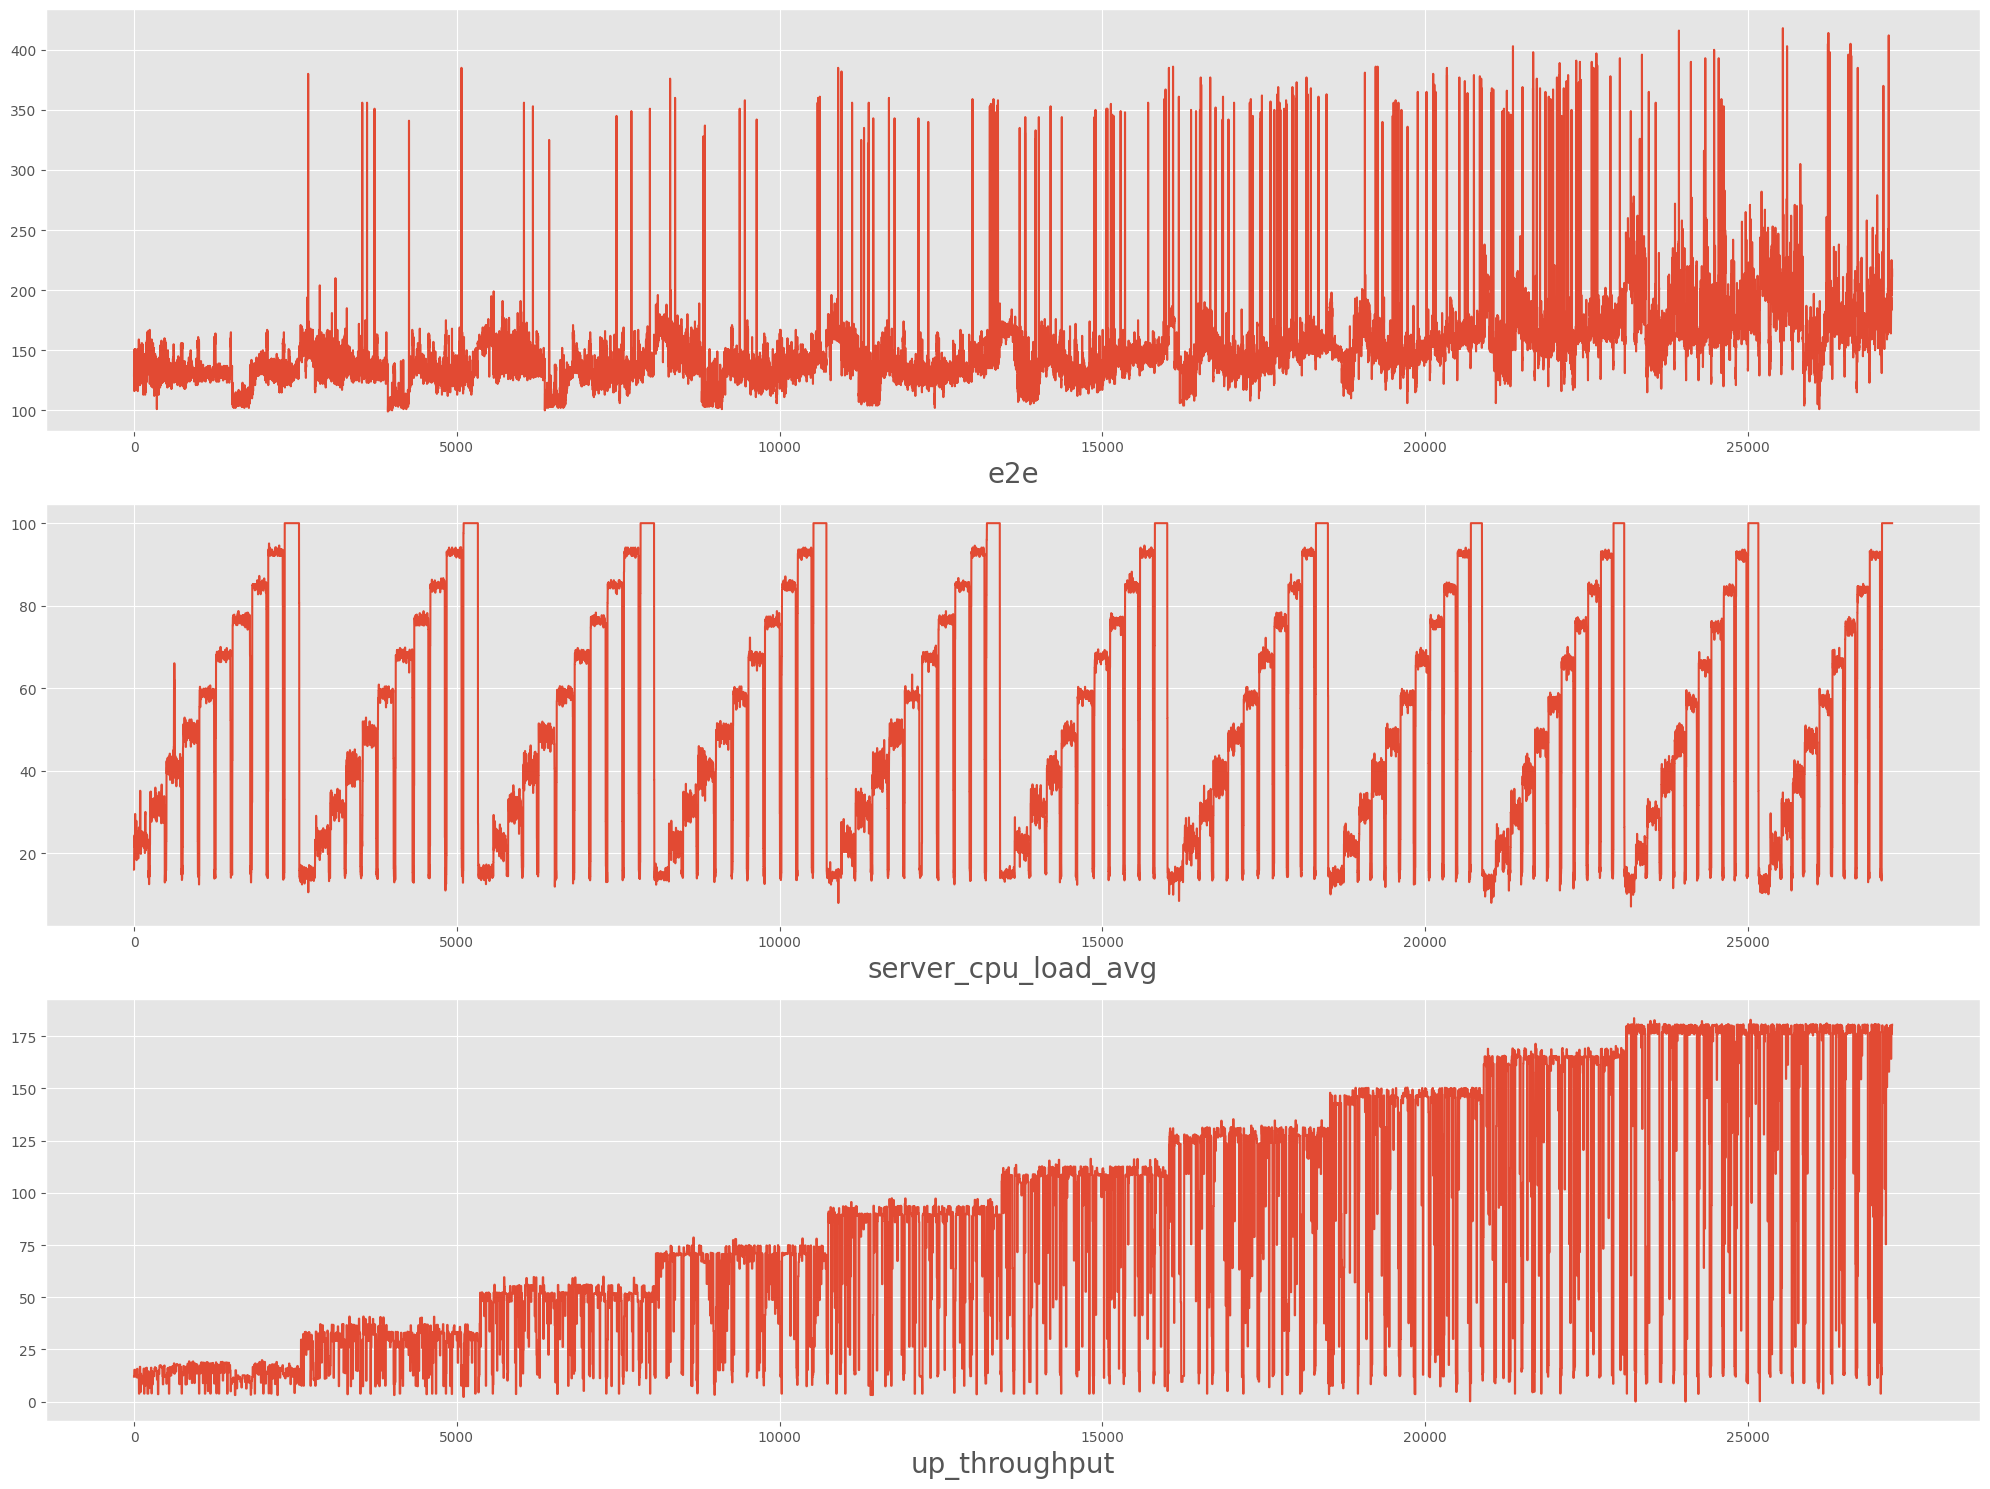

In [ ]:
my_plot(df, ['server_cpu_load_avg', 'up_throughput'], zoom=slice(None), height=5)